<a href="https://colab.research.google.com/github/BahneTP/spatiotemporal-mining-medsea/blob/main/spatiotemporal_mining_medsea_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting characteristic patterns of marine variables using machine learning in the mediterranean sea - Analysis

In this notebook we apply different statistical techniques on the "Global Ocean Physics Reanalysis" Dataset from Opernicus*.
We will focus on the "Salinity" feature, but all the techniques can be applied on all features.
Furthermore, we download the data as monthly and for a timespan of 10years.

https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download?dataset=cmems_mod_glo_phy_my_0.083deg_P1M-m_202311

In [2]:
!pip install cartopy xarray matplotlib

from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Plotting the Feature as a map.

At first, lets plot a map of the Salinity to showcase local differences.
Since a map is 2-dimensional and can't be show different timesteps in a photo, we apply the "interact" method, which allows us to easily adjust the "time" value.

cbar_max and cbar_min are variables of the colourbar, since we might change it's view, depending on how important we find some area to be. We will focus on the mediterranean sea, so let's set it like this.

In [3]:
#     xxx  For Temperature  xxx
column = "Temperature"
cbar_Min = 13
cbar_Max = 30

#     xxx  For Salinity  xxx
# column = "Salinity"
# cbar_Min = 38
# cbar_Max = 39

In [12]:
ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/file.nc")
feature = "thetao" if column == "Temperature" else "so"
data_full = ds[feature]

lons = ds["longitude"]
lats = ds["latitude"]

# Count of timesteps.
nt = data_full.sizes["time"]

def plot_time(t, cbarmin=cbar_Min, cbarmax=cbar_Max):
    dataT = data_full.isel(time=t)

    fig = plt.figure(figsize=(7, 6))
    ax = plt.axes(projection=ccrs.Mercator())

    # Plot
    p = dataT.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="viridis",
        vmin = cbarmin,
        vmax = cbarmax,
        add_colorbar=False,
        add_labels=False
    )

    cbar_ax = fig.add_axes([0.985, 0.25, 0.02, 0.45])  # [left, bottom, width, height]
    cbar = fig.colorbar(p, cax=cbar_ax, orientation="vertical")
    cbar.set_label(f"{column}", fontsize=10)

    ax.coastlines()
    ax.gridlines(draw_labels=True)
    plt.show()

# Slider
interact(plot_time, t=IntSlider(min=0, max=nt-1, step=1, value=0, description="Time"));


interactive(children=(IntSlider(value=0, description='Time', max=107), IntSlider(value=13, description='cbarmi…

In [24]:
# --- Parameter ---
feature = "so"  # "so" for Salinity
depth_level = 50    # Depth

ds = xr.open_dataset("/content/drive/MyDrive/Colab Notebooks/file.nc")
data = ds[feature].sel(depth=depth_level, method="nearest")  # → dims: time, lat, lon

# Adding month as a coordinate.
data = data.assign_coords(month=data["time"].dt.month)

# Calculating the Z-Scores within each month.
def standardize(group):
    m = group.mean("time")
    s = group.std("time")
    return (group - m) / s

z = data.groupby("month").apply(standardize)  # dims: time, lat, lon
z = z.stack(location=("latitude", "longitude"))  # dims: time, location (Uniting lat & lon)
z = z.dropna(dim="location", how="any")   # Removing NaN's

z_df = z.to_pandas()


In [28]:
# --- 1. Datenmatrix: Orte als Zeilen, Zeitverlauf als Merkmale ---
X = z_df.T.values  # Shape: (n_locations, n_timepoints)

# --- 2. K-means ---
k = 4
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
labels = kmeans.fit_predict(X)  # Länge = n_locations

# --- 3. Labels zu DataFrame-Spalten zurückordnen ---
location_index = z_df.columns  # (lat, lon) tuples
cluster_series = pd.Series(labels, index=location_index, name="cluster")


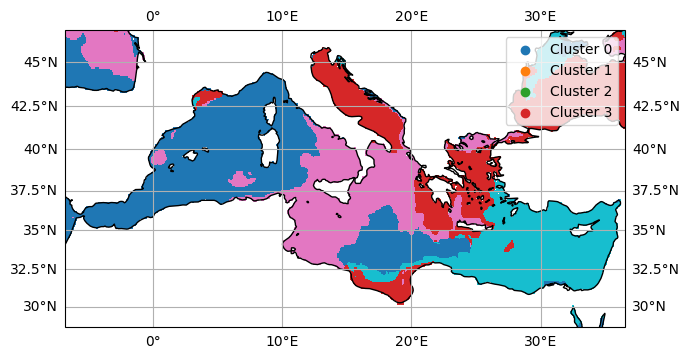

In [29]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Data Preparation
cluster_map = cluster_series.unstack()  # Index = lat, columns = lon → shape: (lat, lon)
lat = cluster_map.index.values
lon = cluster_map.columns.values

fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection=ccrs.Mercator())

# Getting the map
mesh = ax.pcolormesh(
    lon, lat, cluster_map.values,
    cmap="tab10",
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.gridlines(draw_labels=True)

# Legend
for cluster_id in np.unique(labels):
    plt.scatter([], [], c=[plt.cm.tab10(cluster_id)], label=f"Cluster {cluster_id}")
plt.legend(title="", loc="upper right")

plt.tight_layout()
plt.show()

# Dimensionality Reduction with PCA & Plotting

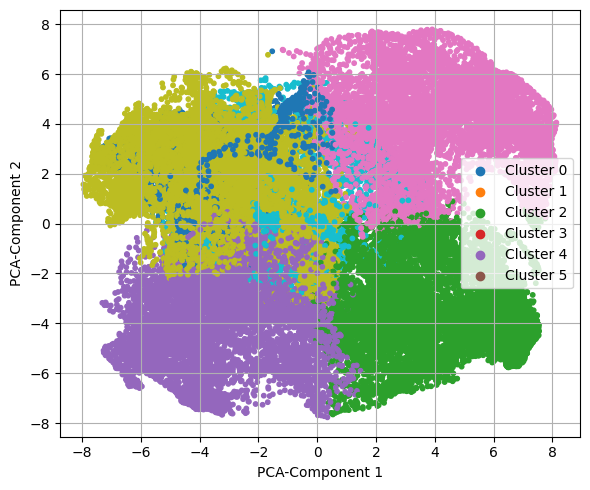

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# --- PCA ---
X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)

# Extracting the labels for the legend
for cluster_id in np.unique(labels):
    plt.scatter([], [], c=[plt.cm.tab10(cluster_id)], label=f"Cluster {cluster_id}")
plt.legend(title="")

plt.xlabel("PCA-Component 1")
plt.ylabel("PCA-Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


The map shows a relatively low temperature at regions where water comes from other sources, like the atlantic ocean in the west or the black sea in the north east.

# Calculating Mean, Standard Deviation and Anomalies.

In [10]:
month_map = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

def plot_multiple_figures(so, grouping, minCb, maxCb, title, fontsize):

    monthly_unit = grouping()

    # Variable domainvalues.
    vmin = float(monthly_unit.min()) if minCb is -1 else minCb
    vmax = float(monthly_unit.max()) if maxCb is -1 else maxCb

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 6),
                            subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()

    # Plot per month.
    for i in range(12):
        ax = axes[i]
        std_map = monthly_unit.sel(month=i+1)

        for spine in ax.spines.values():
          spine.set_visible(False)


        std_map.plot(
            add_labels=False,
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="plasma",
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False  # Show colorbar only once.
        )

        ax.coastlines()
        # ax.gridlines(draw_labels=True)
        ax.text(
            0., 0.3,  # Position in Achsen-Koordinaten (0 = links/unten, 1 = rechts/oben)
            f"{month_map[i+1]}",
            transform=ax.transAxes,  # Koordinatensystem: Achsenbezogen
            fontsize=fontsize,
            verticalalignment="top",
            horizontalalignment="left",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.6)
        )


    # Common colors.
    cbar_ax = fig.add_axes([0.95, 0.1, 0.015, 0.8])  # [left, bottom, width, height]
    img = monthly_unit.sel(month=1).plot(
        ax=axes[0], transform=ccrs.PlateCarree(), cmap="plasma",
        vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False
    )

    fig.colorbar(img, cax=cbar_ax, orientation="vertical")
    cbar = fig.colorbar(img, cax=cbar_ax, orientation="vertical")
    cbar.ax.tick_params(labelsize=fontsize)       # ← Skalenbeschriftung
    cbar.set_label(f"{title} {column}", fontsize=fontsize)      # ← Label-Beschriftung


    plt.tight_layout(rect=[0, 0, 0.94, 1])  # Place for titel and colorbar.
    plt.show()

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-10-977aa10a9843>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  vmin = float(monthly_unit.min()) if minCb is -1 else minCb
<ipython-input-10-977aa10a9843>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  vmax = float(monthly_unit.max()) if maxCb is -1 else maxCb


In [13]:
grouping = lambda: data_full.groupby("time.month").mean("time")
fontsize = 10
title = "Monthly Mean of the"
interact(
    lambda minCb, maxCb: plot_multiple_figures(data_full, grouping, minCb, maxCb, title, fontsize),
    minCb=FloatSlider(min=0, max=50, step=0.5, value=cbar_Min, description="Min"),
    maxCb=FloatSlider(min=0, max=50, step=0.5, value=cbar_Max, description="Max")
)

interactive(children=(FloatSlider(value=13.0, description='Min', max=50.0, step=0.5), FloatSlider(value=30.0, …

<function __main__.<lambda>(minCb, maxCb)>

There is a huge change among the different months. July, August and September have the by far highest temperatures, February and March the coldest.
The observation from the map above can be seen here as well. As it's getting colder over the year, the cold water is coming from other sources.

The map

In [15]:
grouping = lambda: data_full.groupby("time.month").std("time")
fontsize = 10
title = "Monthly Standard Deviation of the"
interact(
    lambda minCb, maxCb: plot_multiple_figures(data_full, grouping, minCb, maxCb, title, fontsize),
    minCb=FloatSlider(min=0, max=5, step=0.1, value=0, description="Min"),
    maxCb=FloatSlider(min=0, max=5, step=0.1, value=1, description="Max")
)

interactive(children=(FloatSlider(value=0.0, description='Min', max=5.0), FloatSlider(value=1.0, description='…

<function __main__.<lambda>(minCb, maxCb)>

Now let's have a look at the monthly standard deviation.
In March, there is an overall low changing in temperature, compared to the other months.

Relatively high changing is happening in may, especially in the ionic sea between italy and croatia and at the southern coast of france.

In comparison to that, the temperature changes pretty different at the coast between egypt and turkye and seems to change much slower.

In [ ]:
import matplotlib.pyplot as plt

def plot_timeseries(data):
    data.plot()
    plt.title(f"{column} Time Series at 40°N, 15°E")
    plt.ylabel(f"{column}")
    plt.xlabel("Time")
    plt.grid(True)
    plt.show()

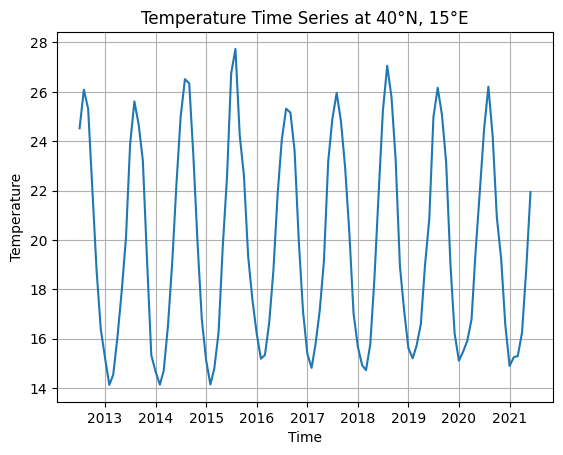

In [ ]:
lat_target = 37.5
lon_target = 0
plot_timeseries(data_full.sel(latitude=lat_target, longitude=lon_target, method="nearest").isel(depth=0))

Here we see the temperature of one specific point. It seems to run pretty even other the whole time, but there is a relatively high difference in the summer of 2015 and the winter of 2016.

There is also a slight tendency of a increase of temperature from 2015 on, especially the winters look like they are getting warmer.

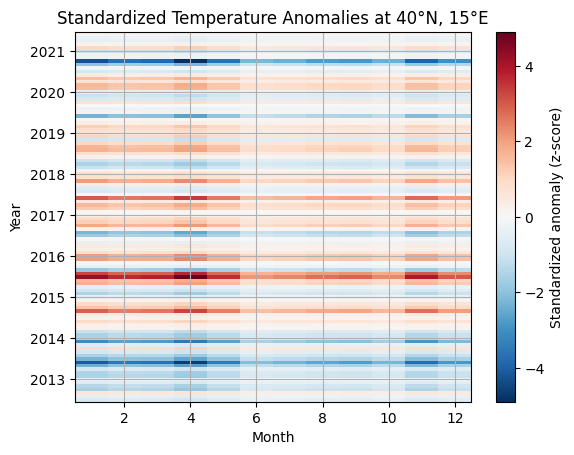

In [ ]:
# Punkt auswählen
point = data_full.sel(latitude=lat_target, longitude=lon_target, method="nearest").isel(depth=0)

# Monatsmittel & Monatsstandardabweichung berechnen
monthly_mean = point.groupby("time.month").mean("time")
monthly_std  = point.groupby("time.month").std("time")

# Standardisierte Anomalien berechnen (Z-Werte)
standardized_anomaly = (point.groupby("time.month") - monthly_mean) / monthly_std

# Plot
standardized_anomaly.plot(
    cmap="RdBu_r",
    cbar_kwargs={"label": "Standardized anomaly (z-score)"}
)
plt.title(f"Standardized {column} Anomalies at 40°N, 15°E")
plt.xlabel("Month")
plt.ylabel("Year")
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)

plt.show()


Here we can see:

  1. From June until October there is much less oscillation in the temperature resulting in less Anomalies.
  2. As seen in the Time-Series before, we observe a relatively higher temperature from the End of 2015 until Summer of 2016.

# Self Organizing Map (SOM)*


Now lets apply a Self Organizing Map on our data.

*https://en.wikipedia.org/wiki/Self-organizing_map

To apply a SOM, we need to reform our data first.

In [ ]:
!pip install minisom
import numpy as np
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=c01a34a8c49e4f8585476da78a8d24000fecfb77f9fdc1b5094d23f03fac7e33
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [ ]:
Matrix3D = data_full.values  # shape: (time, depth, lat, lon)
Matrix3D = Matrix3D[:, 0, :, :]  # → shape: (time, lat, lon)
Matrix3D = np.transpose(Matrix3D, (1, 2, 0))  # → (lat, lon, time)

# Now lets form the matrix into 2D:
lat, lon, time = Matrix3D.shape
Matrix2D = Matrix3D.reshape(lat * lon, time)  # → shape: (lat*lon, time)
#With lat*lon, each point in our map gets a unique "identification".

#Avoiding NaN's:
valid_mask = ~np.isnan(Matrix2D).any(axis=1)
Matrix_clean = Matrix2D[valid_mask]

In [ ]:
X = StandardScaler().fit_transform(Matrix_clean)
som = MiniSom(x=3, y=3, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(X, 1000)

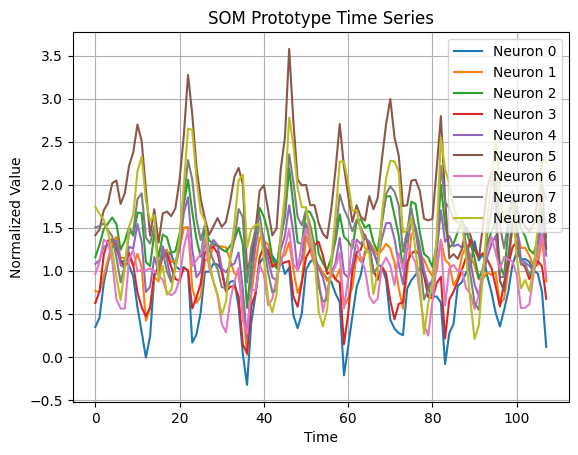

In [ ]:
proto_flat = som.get_weights().reshape(-1, X.shape[1])  # (n_neurons, time)

for i, vec in enumerate(proto_flat):
    plt.plot(vec, label=f"Neuron {i}")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.title("SOM Prototype Time Series")
plt.legend()
plt.grid(True)
plt.show()

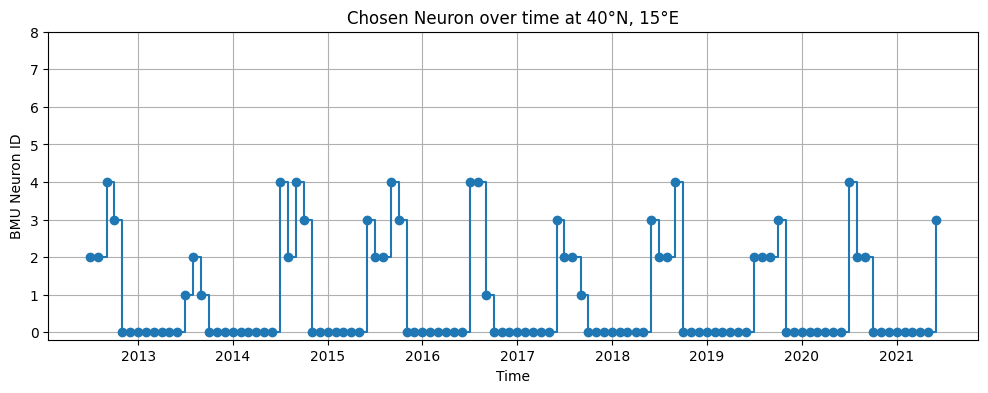

In [ ]:
lat_target = 40
lon_target = 15
point_series = data_full.sel(latitude=lat_target, longitude=lon_target, method="nearest").isel(depth=0)

# Get values and check for NaN's
values = point_series.values
if np.isnan(values).any():
    raise ValueError("Zeitreihe enthält NaNs – Punkt ist ungeeignet.")

# Standardize.
scaler = StandardScaler()
values_std = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Calculate BMU's
bmus = np.array([som.winner([v]) for v in values_std])

# Get linear ID's
som_x, som_y = som.get_weights().shape[:2]
bmu_ids = np.array([i * som_y + j for i, j in bmus])

# Timeline
time_vals = point_series["time"].values

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_vals, bmu_ids, drawstyle="steps-post", marker="o", linestyle="-")
plt.ylabel("BMU Neuron ID")
plt.xlabel("Time")
plt.yticks(range(som_x * som_y))
plt.title(f"Chosen Neuron over time at {lat_target}°N, {lon_target}°E")
plt.grid(True)
plt.show()

# PCA